# Lagrangian NN (LNN)

- Original code from Y. Chen

- Modified by Jae Hoon (Daniel) Lee

In [1]:
import torch
from torch.autograd import grad
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp

seed = 36
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True


In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/target_dp_sep_sc.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/input_dp_sep_sc.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
class LNN(nn.Module):
    def __init__(self, L):
        super().__init__()
        self.L = L
    def forward(self, x):
        with torch.set_grad_enabled(True):
            self.n = n = x.shape[1]//2
            qqd = x.requires_grad_(True)
            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0] ;
            DL_q, DL_qd = J[:,:n], J[:,n:]
            DDL_qd = []
            for i in range(n):
                J_qd_i = DL_qd[:,i][:,None]
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None]
                DDL_qd.append(H_i)
            DDL_qd = torch.cat(DDL_qd, 2)
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:])
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T)
        return torch.cat([qqd[:,self.n:], qdd], 1)
    def _lagrangian(self, qqd):
        return self.L(qqd)

    def energy(self, qqd):
        n = qqd.shape[1]//2
        lag = self.L(qqd)
        lag_sum = lag.sum()
        lag_grad = grad(lag_sum, qqd, create_graph=False)[0] ;
        DL_q, DL_qd = lag_grad[:,:n], lag_grad[:,n:]
        dq = qqd[:,n:]
        inner_prod = (dq*DL_qd).sum(1, keepdim=True)
        energy = lag - inner_prod
        return energy    

In [5]:
import time
input_size = 4
hidden_size = 200
output_size = 1

num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range (num_trials):
  l_nn = LNN(nn.Sequential(
          nn.Linear(input_size,hidden_size),
          nn.Tanh(),
          nn.Linear(hidden_size,hidden_size),
          nn.Tanh(),
          nn.Linear(hidden_size,output_size))
       ).to(device)
  
  
  num_epochs = 2000

  criterion = nn.MSELoss()

  optimizer = optim.Adam(params=l_nn.parameters(),lr=0.0001)

  history_loss = []
  history_eval = []
  history_acc = []
  cnt = 0
  startt = time.time()
  for epoch in range(num_epochs):
    l_nn.train()

    total_loss = 0.0
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = l_nn.forward(data.to(device))

      loss = criterion(output,target.to(device))
      loss.backward()
      optimizer.step()

      total_loss = total_loss+loss.cpu().item()
      cnt = cnt + 1
    total_loss = total_loss/cnt

    num_correct = 0
    num_data = 0
    l_nn.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      output = l_nn.forward(data.to(device))
      eval_loss = eval_loss+criterion(output,target.to(device)).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt
  
    history_loss.append(total_loss)
    history_eval.append(eval_loss)

    if total_loss == np.min(history_loss):
      min_total_loss_in_tl = total_loss
      min_evaluation_loss_in_tl = eval_loss
      min_train_index = epoch+1

    if eval_loss == np.min(history_eval):
      min_evalation_loss_in_el = eval_loss
      min_total_loss_in_el = total_loss
      min_evaluation_index = epoch+1
      path = "./model/danieljh_lnn_dp_sep_sc_min_2t_lr_{}".format(trial)
      torch.save(l_nn.state_dict(), path)
  
    #print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  print("When the training loss value is smallest: {}/{} min training loss:{}, min evalation loss:{}".format(min_train_index,num_epochs,min_total_loss_in_tl,min_evaluation_loss_in_tl))
  print("When the evaluation loss value is smallest: {}/{} min training loss:{}, min evalation loss:{}".format(min_evaluation_index,num_epochs,min_total_loss_in_el,min_evalation_loss_in_el))

  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))

2000/2000 training loss:0.00044089775938118694,evaluation loss:0.000458779261316522
When the training loss value is smallest: 2000/2000 min training loss:0.00044089775938118694, min evalation loss:0.000458779261316522
When the evaluation loss value is smallest: 1998/2000 min training loss:0.0004452824714462622, min evalation loss:0.0004503855321672745
2000/2000 training loss:4.432923672022298,evaluation loss:5.8502650407142935
When the training loss value is smallest: 1297/2000 min training loss:0.0004410032544001297, min evalation loss:0.0004294183228921611
When the evaluation loss value is smallest: 1305/2000 min training loss:0.0004452977775144973, min evalation loss:0.0004176720824034419
2000/2000 training loss:3187.02610578835,evaluation loss:14422.828823840618
When the training loss value is smallest: 301/2000 min training loss:0.0553270437172614, min evalation loss:0.05999310091137886
When the evaluation loss value is smallest: 301/2000 min training loss:0.0553270437172614, min 

In [6]:
import pandas as pd
A = pd.read_csv("./data/A_dp_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B_dp_sep_sc.csv", header=None, dtype=np.float32)
A = np.asmatrix(A)
B = np.asmatrix(B)

(0.01825532, 0.52412613, 0.33688556, 0.20706259)


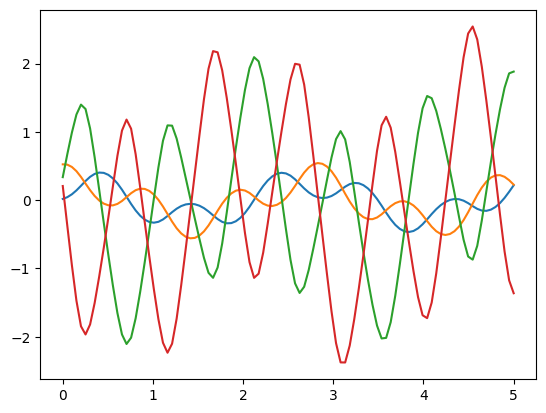

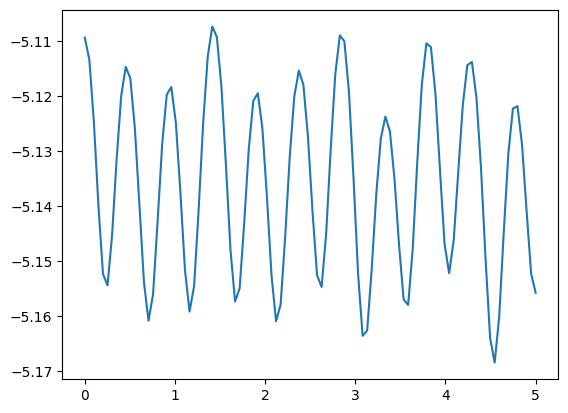

In [ ]:
# simulation
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

trial = num_trials - 1

l_nn.load_state_dict(torch.load("./model/danieljh_lnn_dp_sep_sc_min_2t_lr_{}".format(trial), map_location=device))
l_nn.eval()
teval = torch.linspace(0.0,5.0,100)

# initial value: (q1, q2, v1, v2)
x0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)

print(x0)
dt = teval[1]-teval[0]
teval = teval.detach().cpu().numpy()
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
l_nn.eval()
l_nn.cpu()

def fvec_np(x,t):
    tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)
    x = torch.matmul(tx, torch.inverse(B))
    output = l_nn.forward(x).squeeze(0)
    output = torch.matmul(A, output)
    output = output.squeeze(0)
    return output.detach().cpu().numpy() 

res = scipy.integrate.odeint(fvec_np,x0,teval)

plt.plot(teval,res[:,0])
plt.plot(teval,res[:,1])
plt.plot(teval,res[:,2])
plt.plot(teval,res[:,3])
plt.show()

plt.show()

tres = torch.tensor(res, dtype=torch.float, requires_grad=True)
net_energy = l_nn.energy(torch.matmul(tres, torch.inverse(B)))
plt.plot(teval,net_energy.detach().cpu().numpy())
plt.show()

In [ ]:
M1, M2, L1, L2, G = m1, m2, l1, l2, g

def Hamiltonian_ftn_double_pendulum(q1, q2, v1, v2, m1, m2, l1, l2, g):
    """
    Based on the given state vector (q1, q2, v1, v2), 
    computes the total energy (Hamiltonian) of the double-pendulum system.

    Here:
    q1 = theta1 (Angle 1)
    q2 = theta2 (Angle 2)
    v1 = omega1 (Angular Velocity 1)
    v2 = omega2 (Angular Velocity 2)
    """
    theta1 = q1
    theta2 = q2
    omega1 = v1
    omega2 = v2
    
    # --- Kinetic Energy ---   
    T1 = 0.5 * M1 * (L1 * omega1)**2
    T2 = 0.5 * M2 * (
        (L1 * omega1)**2 + 
        (L2 * omega2)**2 + 
        2 * L1 * L2 * omega1 * omega2 * np.cos(theta1 - theta2)
    )
    kinetic_energy = T1 + T2
    
    # --- Potential Energy ---
    V1 = -M1 * G * L1 * np.cos(theta1)
    V2 = -M2 * G * (L1 * np.cos(theta1) + L2 * np.cos(theta2))
    potential_energy = V1 + V2

    return (kinetic_energy + potential_energy)

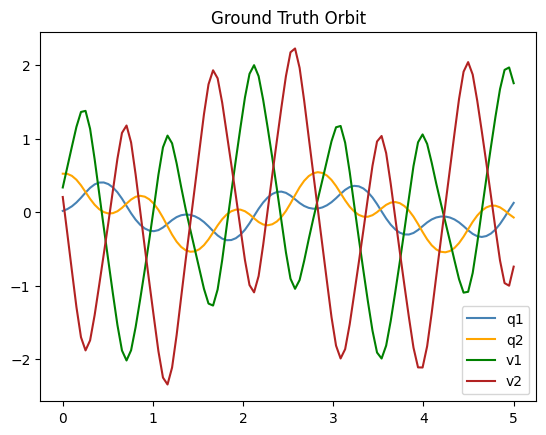

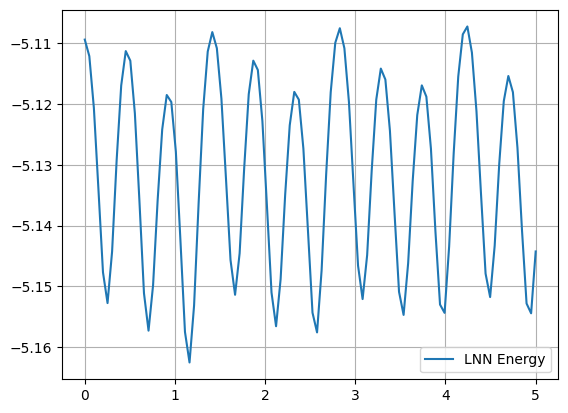

In [9]:
# Ground truth
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

# equations of motion
def func(t, state):
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  return dvdt

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

state = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state.append(s)
x0 = state[0]

sol = solver(func, [0, tend], x0, t_eval=t_eval)

tval = sol['t']
true_x = sol['y'].T # (M, 4) [q1, q2, p1, p2]

# 플롯
ax=plt.subplot()
ax.plot(tval, true_x[:, 0], 'steelblue', label='q1')
ax.plot(tval, true_x[:, 1], 'orange', label='q2')
ax.plot(tval, true_x[:, 2], 'g', label='v1')
ax.plot(tval, true_x[:, 3], 'firebrick', label='v2')
ax.legend()
plt.title("Ground Truth Orbit")
plt.show()

tres = torch.tensor(true_x, dtype=torch.float, requires_grad=True)
lnn_energy_true_x = l_nn.energy(torch.matmul(tres, torch.inverse(B)))
plt.plot(tval,lnn_energy_true_x.detach().cpu().numpy(), label='LNN Energy')
plt.legend()
plt.grid(True)
plt.show()

(0.01825532, 0.52412613, 0.33688556, 0.20706259)


/tmp/ipykernel_101937/280402856.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
/tmp/ipykernel_101937/280402856.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(B, dtype=torch.float32)


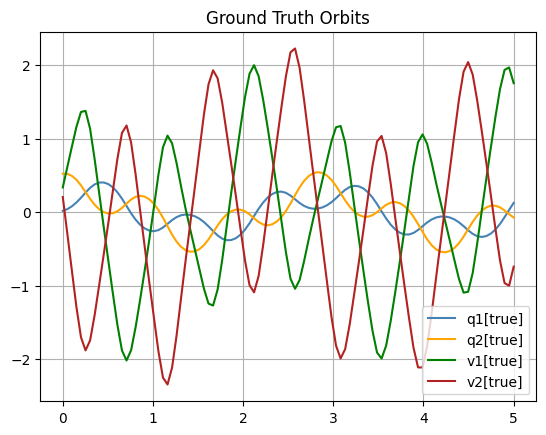

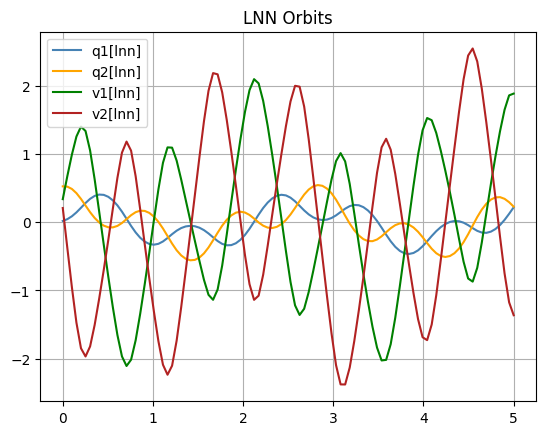

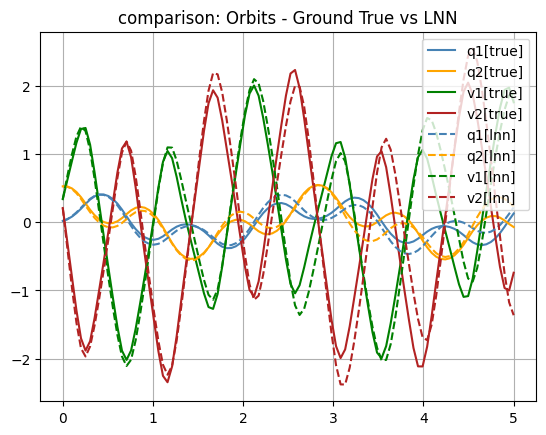

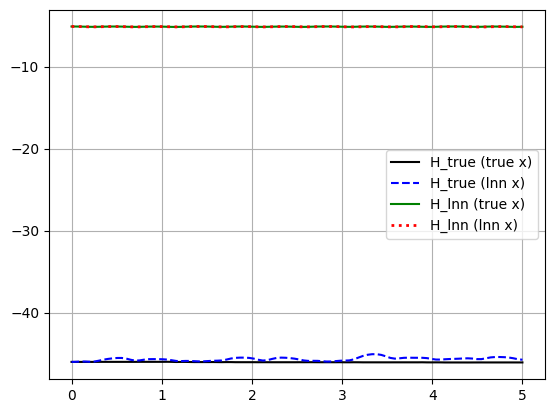

In [10]:
x0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)

print(x0)
dt = teval[1]-teval[0]
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
l_nn.eval()
l_nn.cpu()

def fvec_np(x,t):
    tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)
    x = torch.matmul(tx, torch.inverse(B))
    output = l_nn.forward(x).squeeze(0)
    output = torch.matmul(A, output)
    output = output.squeeze(0)
    return output.detach().cpu().numpy() 

res = scipy.integrate.odeint(fvec_np,x0,teval)

lnn_x = res.copy()
plt.title("Ground Truth Orbits")
plt.plot(tval, true_x[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x[:,1], 'orange', label='q2[true]', linestyle='-')
plt.plot(tval, true_x[:,2], 'g', label='v1[true]', linestyle='-')
plt.plot(tval, true_x[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("LNN Orbits")
plt.plot(tval, lnn_x[:,0], 'steelblue', label='q1[lnn]', linestyle='-')
plt.plot(tval, lnn_x[:,1], 'orange', label='q2[lnn]', linestyle='-')
plt.plot(tval, lnn_x[:,2], 'g', label='v1[lnn]', linestyle='-')
plt.plot(tval, lnn_x[:,3], 'firebrick', label='v2[lnn]',linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("comparison: Orbits - Ground True vs LNN")
plt.plot(tval, true_x[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x[:,1], 'orange', label='q2[true]', linestyle='-')
plt.plot(tval, true_x[:,2], 'g', label='v1[true]', linestyle='-')
plt.plot(tval, true_x[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.plot(tval, lnn_x[:,0], 'steelblue', label='q1[lnn]', linestyle='--')
plt.plot(tval, lnn_x[:,1], 'orange', label='q2[lnn]', linestyle='--')
plt.plot(tval, lnn_x[:,2], 'g', label='v1[lnn]', linestyle='--')
plt.plot(tval, lnn_x[:,3], 'firebrick', label='v2[lnn]',linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

tensor_lnn_x = torch.tensor(lnn_x, dtype=torch.float, requires_grad=True)
lnn_energy_lnn_x = l_nn.energy(torch.matmul(tensor_lnn_x, torch.inverse(B)))

tensor_true_x = torch.tensor(true_x, dtype=torch.float, requires_grad=True)
lnn_energy_true_x = l_nn.energy(torch.matmul(tensor_true_x, torch.inverse(B)))

true_energy_lnn_x = Hamiltonian_ftn_double_pendulum(lnn_x[:,0], lnn_x[:,1], lnn_x[:,2], lnn_x[:,3], m1, m2, l1, l2, g)
true_energy_true_x = Hamiltonian_ftn_double_pendulum(true_x[:,0], true_x[:,1], true_x[:,2], true_x[:,3], m1, m2, l1, l2, g)

plt.plot(teval,true_energy_true_x, label='H_true (true x)', color='k', linestyle='-')
plt.plot(teval,true_energy_lnn_x, label='H_true (lnn x)', color='b',linestyle='--')
plt.plot(teval,lnn_energy_true_x.detach().numpy(), label='H_lnn (true x)', color='g', linestyle='-', lw=1.5)
plt.plot(teval,lnn_energy_lnn_x.detach().numpy(), label='H_lnn (lnn x)', color='r', linestyle=':', lw=2)
plt.legend()
plt.grid(True)
plt.show()